In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn import linear_model, neural_network
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer, mean_squared_error, r2_score, f1_score, classification_report
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

from functools import reduce

import warnings 
warnings.simplefilter(action = 'ignore', category=FutureWarning) 

In [2]:
# imprime le dossier actuel de travail
os.getcwd()

'/home/adelphe/Bureau/Aide Emeline code'

In [3]:
# imprimes les fichiers dans votre dossier actuel
os.listdir() 

['house.ipynb',
 'house (1).ipynb',
 'kc_house_data.csv',
 '.ipynb_checkpoints',
 'Variables description.pdf']

In [4]:
# Read the Datafile
dataset = pd.read_csv('kc_house_data.csv')

In [5]:
# Pour dupliquer un dataset, utiliser la fonction copy() au lieu de l'affectation "df = dataset"
df = dataset.copy()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
# Lister les colonnes du dataset
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
# Unique values
df.groupby('condition')['id'].nunique()

condition
1       29
2      164
3    13911
4     5645
5     1687
Name: id, dtype: int64

# Section 1 - Prétraitement des données

## 1 - Grade

In [8]:
# Unique values
df.groupby('grade')['id'].nunique()

grade
1        1
3        3
4       29
5      234
6     1995
7     8896
8     6044
9     2606
10    1130
11     396
12      89
13      13
Name: id, dtype: int64

#### NB:
Le grade 2 ne comporte aucune observation. On va le retirer de la liste.

Nous allons combiner les grade 1, 3, 4 et 5.

Nous allons combiner les grades 11, 12 et 13.

In [9]:
df.grade.replace([1, 3, 4], 5, inplace=True)
df.grade.replace([12, 13], 11, inplace=True)
df['grade'] = df['grade'] - 4
df.groupby('grade')['id'].nunique()

grade
1     267
2    1995
3    8896
4    6044
5    2606
6    1130
7     498
Name: id, dtype: int64

## 2 - Date (Date, yr_renovated, yr_built)

In [10]:
# Prendre le max entre yr_renovated et yr_built. Si la maison a été renovée, alors on considérera son année de 
# renovation. Dans le cas contraire, on considèrera son année de construction
df['yr_renovated'] = np.maximum(df['yr_built'], df['yr_renovated'])

# Conserver seulement l'année dans la date de vente Date
df['date'] = df.date.apply(lambda x: int(x[:4])) 

# Calculer le nombre d'années entre la dernière rénovation et la vente de la maison
df['date'] = df['date'] - df['yr_renovated'] + 1

df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,60,221900.0,3,1.00,1180,5650,1.0,0,0,...,3,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,24,538000.0,3,2.25,2570,7242,2.0,0,0,...,3,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [11]:
df.groupby('date')['id'].nunique()

date
0       18
1      516
2      330
3      190
4      178
      ... 
112     42
113     31
114     27
115     54
116     21
Name: id, Length: 117, dtype: int64

## 3 - ZipCode

In [12]:
# Convertir le zipcode en string
df['zipcode'] = df['zipcode'].astype(str)

# Conserver seulement les 4 premiers caractères du zipcode
df['zipcode'] = df['zipcode'].apply(lambda x: x[:4])

df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,60,221900.0,3,1.00,1180,5650,1.0,0,0,...,3,1180,0,1955,1955,9817,47.5112,-122.257,1340,5650
1,6414100192,24,538000.0,3,2.25,2570,7242,2.0,0,0,...,3,2170,400,1951,1991,9812,47.7210,-122.319,1690,7639


In [13]:
# Unique values 
df.groupby('zipcode')['id'].nunique()

zipcode
9800    2227
9801     606
9802    1819
9803    2258
9804    1048
9805    2553
9806     307
9807    1378
9809     351
9810    1822
9811    2404
9812    1044
9813     748
9814     677
9815     442
9816     514
9817     512
9818     135
9819     591
Name: id, dtype: int64

## Transformer les variables catégorielles en dummies

In [14]:
cols = ['waterfront','zipcode']
df_dum = pd.get_dummies(df, columns=cols)
df_dum.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,zipcode_9810,zipcode_9811,zipcode_9812,zipcode_9813,zipcode_9814,zipcode_9815,zipcode_9816,zipcode_9817,zipcode_9818,zipcode_9819
0,7129300520,60,221900.0,3,1.00,1180,5650,1.0,0,3,...,0,0,0,0,0,0,0,1,0,0
1,6414100192,24,538000.0,3,2.25,2570,7242,2.0,0,3,...,0,0,1,0,0,0,0,0,0,0


## Séparer notre jeu de données en un ensemble d'entraînement et un de test

In [15]:
# Jeu de données d'entraînement x

x = df_dum.drop(['id', 'sqft_living', 'sqft_lot', 'grade', 'lat', 'long', 'yr_built', 'yr_renovated'], axis=1)

#'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
#       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
#       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
#       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
 



# Jeu de données de test y
y = df_dum['grade']

# Diviser en Train/Test
# On garde 20% des données pour l'ensemble de test.
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=False)

In [16]:
x.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'waterfront_0', 'waterfront_1', 'zipcode_9800', 'zipcode_9801',
       'zipcode_9802', 'zipcode_9803', 'zipcode_9804', 'zipcode_9805',
       'zipcode_9806', 'zipcode_9807', 'zipcode_9809', 'zipcode_9810',
       'zipcode_9811', 'zipcode_9812', 'zipcode_9813', 'zipcode_9814',
       'zipcode_9815', 'zipcode_9816', 'zipcode_9817', 'zipcode_9818',
       'zipcode_9819'],
      dtype='object')

In [17]:
x_train.head(2)

,date,price,bedrooms,bathrooms,floors,view,condition,sqft_above,sqft_basement,sqft_living15,...,zipcode_9810,zipcode_9811,zipcode_9812,zipcode_9813,zipcode_9814,zipcode_9815,zipcode_9816,zipcode_9817,zipcode_9818,zipcode_9819
0,60,221900.0,3,1.00,1.0,0,3,1180,0,1340,...,0,0,0,0,0,0,0,1,0,0
1,24,538000.0,3,2.25,2.0,0,3,2170,400,1690,...,0,0,1,0,0,0,0,0,0,0


In [18]:
x_test.head(2)

,date,price,bedrooms,bathrooms,floors,view,condition,sqft_above,sqft_basement,sqft_living15,...,zipcode_9810,zipcode_9811,zipcode_9812,zipcode_9813,zipcode_9814,zipcode_9815,zipcode_9816,zipcode_9817,zipcode_9818,zipcode_9819
17290,48,380000.0,4,2.5,1.0,0,3,1540,730,2020,...,0,0,0,0,0,0,0,0,0,0
17291,49,624900.0,4,2.5,1.0,0,3,1540,730,2020,...,0,0,0,0,0,0,0,0,0,0


In [19]:
type(y_train)

pandas.core.series.Series

In [20]:
y_test.head(2)

17290    4
17291    4
Name: grade, dtype: int64

# Section 2 - Modélisation

## 2.1 Régression linéaire

In [21]:
# Créer l'objet de régression linéaire
model_linear = LinearRegression()

# Entraîner le modèle à partir des données d'entraînement
model_linear.fit(x_train, y_train)

print("Number of parameters: ", model_linear.coef_.shape[0]+1)

Number of parameters:  33


In [22]:
# Obtenir les prédictions d'entraînement
y_train_pred = model_linear.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = model_linear.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(model_linear, x_train, y_train, cv=10, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(model_linear, x_train, y_train, cv=10, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction d'entraînement est : %.3f" % model_linear.score(x_train, y_train))

## Obtenir le score de TEST
print("Le score de prédiction de test est : %.3f" % model_linear.score(x_test, y_test))

Erreur carrée moyenne d'entraînement: 0.359
Erreur carrée moyenne de test: 0.397
L erreur absolue moyenne est: 0.462
L erreur quadratique moyenne est: 0.36112
Le score R2 est: 0.726
Le score de prédiction d'entraînement est : 0.726
Le score de prédiction de test est : 0.699


In [23]:
# Créer le modèle de régression linéaire régularisé
regr = Ridge(alpha=10)

# Entraîner le modèle avec l'ensemble d'entraînement
start = time.time()
regr.fit(x_train, y_train)
fit_time = time.time() - start

print("Temps d'apprentissage: %.2f seconds" % fit_time)

print("Nombre de paramètres:", regr.coef_.shape[0]+1)

Temps d'apprentissage: 0.53 seconds
Nombre de paramètres: 33


In [24]:
# Obtenir les prédictions sur l'ensemble d'entraînement
y_train_pred = regr.predict(x_train)

print("Erreur au carré moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions sur l'ensemble de test
y_test_pred = regr.predict(x_test)

print("Erreur au carré moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Erreur au carré moyenne d'entraînement: 0.359
Erreur au carré moyenne de test: 0.397


In [25]:
### Cette cellule peut prendre plusieurs minutes à s'exécuter

# Créer l'objet de régression linéaire
regRCV = RidgeCV(alphas=[0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000])

# Entraîner le modèle à partir de l'ensemble d'entraînement
regRCV.fit(x_train, y_train)

print("Nombre de paramètres: %d, estimated alpha: %d" % (regRCV.coef_.shape[0], regRCV.alpha_))

Nombre de paramètres: 32, estimated alpha: 10


## 2.2 Forests of randomized trees

In [26]:
# Créer l'objet
forestmodel = RandomForestClassifier(n_estimators=400, 
                              random_state=0, n_jobs=-1)

# Entraîner le modèle à partir des données d'entraînement
forestmodel.fit(x_train,y_train.values.ravel())

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0)

In [27]:
# Obtenir les prédictions d'entraînement
y_train_pred = forestmodel.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = forestmodel.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(forestmodel, x_train, y_train, cv=10, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(forestmodel, x_train, y_train, cv=10, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction d'entraînement est : %.3f" % forestmodel.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction est : %.3f" % forestmodel.score(x_test, y_test))

print("le score de la precision de Foret aléatoire : " +str(accuracy_score(y_test_pred ,y_test)))

print(classification_report(y_test, y_test_pred, digits=4))

Erreur carrée moyenne d'entraînement: 0.000
Erreur carrée moyenne de test: 0.370
L erreur absolue moyenne est: 0.308
L erreur quadratique moyenne est: 0.33991
Le score R2 est: 1.000
Le score de prédiction d'entraînement est : 1.000
Le score de prédiction est : 0.695
le score de la precision de Foret aléatoire : 0.6948878093916262
              precision    recall  f1-score   support

           1     0.8000    0.2051    0.3265        39
           2     0.7083    0.5977    0.6483       256
           3     0.7678    0.7790    0.7734      1439
           4     0.6703    0.7609    0.7127      1464
           5     0.6218    0.5810    0.6007       716
           6     0.6157    0.4524    0.5216       294
           7     0.6556    0.5130    0.5756       115

    accuracy                         0.6949      4323
   macro avg     0.6914    0.5556    0.5941      4323
weighted avg     0.6940    0.6949    0.6904      4323



## 2.3 Decision trees

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
# Créer l'objet
decisionmodel = DecisionTreeClassifier(random_state=0)

# Entraîner le modèle à partir des données d'entraînement
decisionmodel.fit(x_train,y_train.values.ravel())

DecisionTreeClassifier(random_state=0)

In [30]:
# Obtenir les prédictions d'entraînement
y_train_pred = decisionmodel.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = decisionmodel.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(decisionmodel, x_train, y_train, cv=5, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(decisionmodel, x_train, y_train, cv=5, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction moyenne du train est : %.3f" % decisionmodel.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction moyenne du test est : %.3f" % decisionmodel.score(x_test, y_test))

print("le score de la precision de l'Arbre de décision:" +str(accuracy_score(y_test, y_test_pred)))

print(classification_report(y_test, y_test_pred, digits=4))

Erreur carrée moyenne d'entraînement: 0.000
Erreur carrée moyenne de test: 0.643
L erreur absolue moyenne est: 0.452
L erreur quadratique moyenne est: 0.55327
Le score R2 est: 1.000
Le score de prédiction moyenne du train est : 1.000
Le score de prédiction moyenne du test est : 0.564
le score de la precision de l'Arbre de décision:0.5641915336571826
              precision    recall  f1-score   support

           1     0.3235    0.2821    0.3014        39
           2     0.4813    0.5039    0.4924       256
           3     0.6341    0.6442    0.6391      1439
           4     0.5863    0.5895    0.5879      1464
           5     0.4850    0.4749    0.4799       716
           6     0.4036    0.3844    0.3937       294
           7     0.5283    0.4870    0.5068       115

    accuracy                         0.5642      4323
   macro avg     0.4917    0.4808    0.4859      4323
weighted avg     0.5629    0.5642    0.5634      4323



## 2.4 Plus proches voisins

In [31]:
# Créer l'objet
knn = KNeighborsClassifier()

# Entraîner le modèle à partir des données d'entraînement
knn.fit(x_train,y_train.values.ravel())

KNeighborsClassifier()

In [32]:
# Obtenir les prédictions d'entraînement
y_train_pred = knn.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = knn.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(knn, x_train, y_train, cv=5, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(knn, x_train, y_train, cv=5, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction moyenne du train est : %.3f" % knn.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction moyenne du test est : %.3f" % knn.score(x_test, y_test))

print("le score de la precision de l'Arbre de décision:" +str(accuracy_score(y_test, y_test_pred)))

print(classification_report(y_test, y_test_pred, digits=4))

Erreur carrée moyenne d'entraînement: 0.546
Erreur carrée moyenne de test: 0.823
L erreur absolue moyenne est: 0.565
L erreur quadratique moyenne est: 0.75714
Le score R2 est: 0.583
Le score de prédiction moyenne du train est : 0.667
Le score de prédiction moyenne du test est : 0.497
le score de la precision de l'Arbre de décision:0.49733981031690955
              precision    recall  f1-score   support

           1     0.2857    0.1026    0.1509        39
           2     0.3659    0.3516    0.3586       256
           3     0.5183    0.7380    0.6089      1439
           4     0.5092    0.4706    0.4892      1464
           5     0.4522    0.2709    0.3389       716
           6     0.4304    0.2313    0.3009       294
           7     0.5811    0.3739    0.4550       115

    accuracy                         0.4973      4323
   macro avg     0.4490    0.3627    0.3861      4323
weighted avg     0.4889    0.4973    0.4796      4323



## 2.5 Machines à vecteurs de support

In [33]:
# Créer l'objet de régression linéaire
SVM = SVC(C=10000, gamma=0.0001, random_state=1234)

# Entraîner le modèle à partir des données d'entraînement
SVM.fit(x_train, y_train)


SVC(C=10000, gamma=0.0001, random_state=1234)

In [34]:
# Obtenir les prédictions d'entraînement
y_train_pred = SVM.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = SVM.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(SVM, x_train, y_train, cv=5, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(SVM, x_train, y_train, cv=5, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction moyenne du train est : %.3f" % SVM.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction moyenne du test est : %.3f" % SVM.score(x_test, y_test))

print("le score de la precision de l'Arbre de décision:" +str(accuracy_score(y_test, y_test_pred)))

print(classification_report(y_test, y_test_pred, digits=4))

Erreur carrée moyenne d'entraînement: 0.000
Erreur carrée moyenne de test: 2.129
L erreur absolue moyenne est: 0.849
L erreur quadratique moyenne est: 1.65442
Le score R2 est: 1.000
Le score de prédiction moyenne du train est : 1.000
Le score de prédiction moyenne du test est : 0.337
le score de la precision de l'Arbre de décision:0.33726578764746706


C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        39
           2     0.3333    0.0039    0.0077       256
           3     0.3340    0.9972    0.5004      1439
           4     0.9130    0.0143    0.0282      1464
           5     1.0000    0.0014    0.0028       716
           6     0.0000    0.0000    0.0000       294
           7     0.0000    0.0000    0.0000       115

    accuracy                         0.3373      4323
   macro avg     0.3686    0.1453    0.0770      4323
weighted avg     0.6058    0.3373    0.1771      4323



## 2.6 Régression logistique multinomiale

In [35]:
# instantiate models
model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs', max_iter=10000,
    class_weight='balanced')

# Entraîner le modèle à partir des données d'entraiînement
model_multi.fit(x_train, y_train)

print("Number of parameters: ", model_multi.coef_.shape[0]+1)

C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of parameters:  8


In [36]:
# Obtenir les prédictions d'entraînement
y_train_pred = model_multi.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = model_multi.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(model_multi, x_train, y_train, cv=5, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(model_multi, x_train, y_train, cv=5, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction moyenne du train est : %.3f" % model_multi.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction moyenne du test est : %.3f" % model_multi.score(x_test, y_test))

print("le score de la precision de l'Arbre de décision:" +str(accuracy_score(y_test, y_test_pred)))

print(classification_report(y_test, y_test_pred, digits=4))

Erreur carrée moyenne d'entraînement: 3.188
Erreur carrée moyenne de test: 3.440


C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

L erreur absolue moyenne est: 1.226


C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\TOSHIBA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

L erreur quadratique moyenne est: 2.61741
Le score R2 est: -1.434
Le score de prédiction moyenne du train est : 0.237
Le score de prédiction moyenne du test est : 0.202
le score de la precision de l'Arbre de décision:0.20194309507286606
              precision    recall  f1-score   support

           1     0.0653    0.7179    0.1197        39
           2     0.3772    0.4258    0.4000       256
           3     0.7652    0.1404    0.2372      1439
           4     0.4062    0.2131    0.2796      1464
           5     0.1784    0.0601    0.0899       716
           6     0.0697    0.3605    0.1169       294
           7     0.0899    0.6348    0.1575       115

    accuracy                         0.2019      4323
   macro avg     0.2788    0.3647    0.2001      4323
weighted avg     0.4519    0.2019    0.2254      4323



on remarque que certaines variables sont corrélées entre elles.

## VOTING

In [37]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(x_train, y_train.values.ravel())

KNeighborsClassifier()

In [40]:
for model in (decisionmodel,forestmodel,knn):
    print(model.__class__.__name__,model.score(x_test,y_test))


DecisionTreeClassifier 0.5641915336571826
RandomForestClassifier 0.6948878093916262
KNeighborsClassifier 0.49733981031690955


In [41]:
 from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier

In [ ]:
model_voting = VotingClassifier([('arbre_decision',arbre_decision),
                                ('foret_aleatoire',foret_aleatoire)], voting='hard')
model_voting.fit(x_train, y_train)

In [ ]:
for model in (arbre_decision,foret_aleatoire,model_voting):
    print(model.__class__.__name__,model.score(x_test,y_test))


## Bagging

In [ ]:
model = BaggingClassifier(base_estimator = KNeighborsClassifier(), n_estimators=100)
model.fit(x_train,y_train)
model.score(x_test,y_test)

In [ ]:
model = BaggingClassifier(base_estimator = RandomForestClassifier(), n_estimators=100)
model.fit(x_train,y_train)
model.score(x_test,y_test)

## Boosting

In [ ]:
model = AdaBoostClassifier(n_estimators=100)
model.fit(x_train,y_train)
model.score(x_test,y_test)

In [ ]:
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(),n_estimators=100)
model.fit(x_train,y_train)
model.score(x_test,y_test)

## Stacking

In [ ]:
model = StackingClassifier([('arbre_decision',arbre_decision),
                                ('foret_aleatoire',foret_aleatoire)],final_estimator=RandomForestClassifier(n_estimators=100))
model.fit(x_train,y_train)
model.score(x_test,y_test)

## 2.7 Gradient boosting

In [ ]:
# Créer l'objet de régression linéaire
grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                  max_depth=1, random_state=0)

# Entraîner le modèle à partir des données d'entraînement
grad.fit(x_train, y_train)

#print("Number of parameters: ", grad.coef_.shape[0]+1)

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = grad.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = grad.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(grad, x_train, y_train, cv=10, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(grad, x_train, y_train, cv=10, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction d'entraînement est : %.3f" % grad.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction est : %.3f" % grad.score(x_test, y_test))

print("le score de la precision : " +str(accuracy_score(y_test_pred ,y_test)))

print(classification_report(y_test, y_test_pred, digits=4))

## 2.8 Neural network

In [53]:
data = df_dum.drop(['id', 'sqft_living', 'sqft_lot', 'lat', 'long', 'yr_built', 'yr_renovated'], axis=1)
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'waterfront_0', 'waterfront_1', 'zipcode_9800', 'zipcode_9801',
       'zipcode_9802', 'zipcode_9803', 'zipcode_9804', 'zipcode_9805',
       'zipcode_9806', 'zipcode_9807', 'zipcode_9809', 'zipcode_9810',
       'zipcode_9811', 'zipcode_9812', 'zipcode_9813', 'zipcode_9814',
       'zipcode_9815', 'zipcode_9816', 'zipcode_9817', 'zipcode_9818',
       'zipcode_9819'],
      dtype='object')

In [54]:
# STANDARDISATION DES DONNÉES

# Créer l'objet de preprocessing
scaler = StandardScaler()

# Fit and transform without the grade
data[['date', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'waterfront_0', 'waterfront_1', 'zipcode_9800', 'zipcode_9801',
       'zipcode_9802', 'zipcode_9803', 'zipcode_9804', 'zipcode_9805',
       'zipcode_9806', 'zipcode_9807', 'zipcode_9809', 'zipcode_9810',
       'zipcode_9811', 'zipcode_9812', 'zipcode_9813', 'zipcode_9814',
       'zipcode_9815', 'zipcode_9816', 'zipcode_9817', 'zipcode_9818',
       'zipcode_9819']] = scaler.fit_transform(data[['date', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'waterfront_0', 'waterfront_1', 'zipcode_9800', 'zipcode_9801',
       'zipcode_9802', 'zipcode_9803', 'zipcode_9804', 'zipcode_9805',
       'zipcode_9806', 'zipcode_9807', 'zipcode_9809', 'zipcode_9810',
       'zipcode_9811', 'zipcode_9812', 'zipcode_9813', 'zipcode_9814',
       'zipcode_9815', 'zipcode_9816', 'zipcode_9817', 'zipcode_9818',
       'zipcode_9819']])
data

,date,price,bedrooms,bathrooms,floors,view,condition,grade,sqft_above,sqft_basement,...,zipcode_9810,zipcode_9811,zipcode_9812,zipcode_9813,zipcode_9814,zipcode_9815,zipcode_9816,zipcode_9817,zipcode_9818,zipcode_9819
0,0.626907,-0.866717,-0.398737,-1.447464,-0.915427,-0.305759,-0.629187,3,-0.734708,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,6.387851,-0.079576,-0.168544
1,-0.622530,-0.005688,-0.398737,0.175607,0.936506,-0.305759,-0.629187,3,0.460841,0.245141,...,-0.304326,-0.355666,4.416525,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
2,1.425159,-0.980849,-1.473959,-1.447464,-0.915427,-0.305759,-0.629187,2,-1.229834,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
3,0.279841,0.174090,0.676485,1.149449,-0.915427,-0.305759,2.444294,3,-0.891699,1.397515,...,-0.304326,-0.355666,-0.226422,5.248891,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
4,-0.448997,-0.081958,-0.398737,-0.149007,-0.915427,-0.305759,-0.629187,4,-0.130895,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,-1.247248,-0.490545,-0.398737,0.500221,2.788439,-0.305759,-0.629187,4,-0.312039,-0.658681,...,3.285953,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
21609,-1.386075,-0.381588,0.676485,0.500221,0.936506,-0.305759,-0.629187,4,0.629908,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,5.514911,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
21610,-1.247248,-0.375865,-1.473959,-1.772078,0.936506,-0.305759,-0.629187,3,-0.927928,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,5.514911,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
21611,-1.039009,-0.381588,-0.398737,0.500221,0.936506,-0.305759,-0.629187,4,-0.227505,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544


In [192]:
data.shape

(21613, 33)

In [56]:
# Diviser l'ensemble de données en ensembles d'apprentissage et de validation
train, test = train_test_split(data, test_size = 0.2, random_state = 21)

In [57]:
train

,date,price,bedrooms,bathrooms,floors,view,condition,grade,sqft_above,sqft_basement,...,zipcode_9810,zipcode_9811,zipcode_9812,zipcode_9813,zipcode_9814,zipcode_9815,zipcode_9816,zipcode_9817,zipcode_9818,zipcode_9819
862,-0.101931,-0.000512,-0.398737,-0.473621,-0.915427,-0.305759,-0.629187,4,-0.674326,0.290333,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
16466,-0.657236,0.321454,0.676485,0.500221,0.936506,-0.305759,-0.629187,5,0.774823,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
15625,1.008680,-0.790312,1.751707,-0.149007,-0.915427,-0.305759,0.907554,2,-0.070514,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,6.387851,-0.079576,-0.168544
18745,0.557494,-0.926507,-0.398737,-0.798235,0.010539,-0.305759,-0.629187,2,-0.505259,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,6.350201,-0.156547,-0.079576,-0.168544
7848,1.078093,-0.994469,-0.398737,-1.447464,-0.915427,-0.305759,-0.629187,2,-0.770936,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16432,-1.004302,-0.381724,0.676485,0.500221,0.936506,-0.305759,-0.629187,4,0.678213,-0.658681,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
8964,0.835147,-0.539575,-0.398737,-1.447464,-0.915427,-0.305759,0.907554,2,-0.807165,1.284537,...,3.285953,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
5944,-1.039009,-0.416999,-0.398737,0.175607,0.936506,-0.305759,-0.629187,3,-0.589793,-0.331045,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544
5327,0.522787,-0.169123,0.676485,-0.149007,-0.915427,-0.305759,0.907554,3,-0.698479,0.425906,...,-0.304326,-0.355666,-0.226422,-0.190516,-0.181327,-0.145157,-0.157475,-0.156547,-0.079576,-0.168544


In [58]:
# Classer les prédicteurs et les variables cibles ou target en X et Y
X_train = train.loc[:, train.columns != "grade"].values
Y_train = train.loc[:,"grade"].values
X_val = test.loc[:, train.columns != "grade"].values
y_val = test.loc[:,"grade"].values

In [59]:
Y_train

array([4, 5, 2, ..., 3, 3, 3])

In [189]:
neural_network.MLPClassifier?

In [206]:
# Créer un réseau de neuronnes
model_neural = neural_network.MLPClassifier(alpha=0.01, # l2-regularization (weight decay)
    hidden_layer_sizes=(400, 356, 188, 94, 64, 32, 16, 7),
    activation='relu',
    solver='sgd',
    learning_rate="adaptive",
    learning_rate_init=0.1,
    max_iter=500,
    early_stopping=True,
    verbose=1)

# Estimer les paramètres du réseau sur nos données

#normalize data
histo = model_neural.fit(X_train, Y_train)

print("Nombre de paramètres:", reduce(lambda x,y: x+y, 
                                       list(map(lambda x: x.size, model_neural.coefs_+model_neural.intercepts_)) ))

Iteration 1, loss = 1.08266436
Validation score: 0.639676
Iteration 2, loss = 0.86266102
Validation score: 0.621747
Iteration 3, loss = 0.84345382
Validation score: 0.662233
Iteration 4, loss = 0.82573614
Validation score: 0.652400
Iteration 5, loss = 0.80638221
Validation score: 0.666281
Iteration 6, loss = 0.80024158
Validation score: 0.635628
Iteration 7, loss = 0.78683044
Validation score: 0.655870
Iteration 8, loss = 0.77541162
Validation score: 0.684789
Iteration 9, loss = 0.76334785
Validation score: 0.668595
Iteration 10, loss = 0.75108925
Validation score: 0.680162
Iteration 11, loss = 0.74310074
Validation score: 0.681897
Iteration 12, loss = 0.73939018
Validation score: 0.676113
Iteration 13, loss = 0.73025623
Validation score: 0.680162
Iteration 14, loss = 0.71850638
Validation score: 0.669173
Iteration 15, loss = 0.70711919
Validation score: 0.693464
Iteration 16, loss = 0.69813297
Validation score: 0.680740
Iteration 17, loss = 0.68982235
Validation score: 0.692886
Iterat

In [207]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [208]:
y_pred_train = model_neural.predict(X_train)
y_pred = model_neural.predict(X_val)

In [209]:
#Import Confusion Matrix
from sklearn.metrics import confusion_matrix

# Comparer les prédictions aux observations réelles dans y_val
cm_train = confusion_matrix(y_pred_train, Y_train)
cm = confusion_matrix(y_pred, y_val)

# Affichage de l'accuracy
print("Accuracy of MLPClassifier Train: ", accuracy(cm_train))
print("Accuracy of MLPClassifier Test: ", accuracy(cm))

Accuracy of MLPClassifier Train:  0.7975708502024291
Accuracy of MLPClassifier Test:  0.6814712005551701


In [210]:
import seaborn as sns
from cf_matrix import make_confusion_matrix

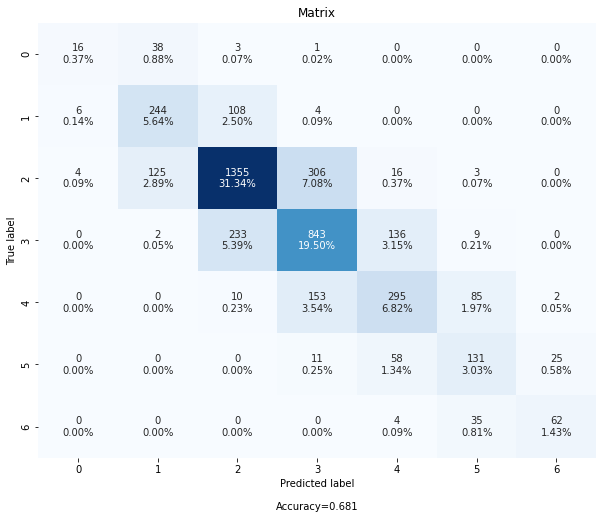

In [211]:
cf_matrix = confusion_matrix( y_val, y_pred)
make_confusion_matrix(cf_matrix, figsize=(10,8), cbar=False, title='Matrix')

In [212]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.28      0.38        58
           2       0.60      0.67      0.63       362
           3       0.79      0.75      0.77      1809
           4       0.64      0.69      0.66      1223
           5       0.58      0.54      0.56       545
           6       0.50      0.58      0.54       225
           7       0.70      0.61      0.65       101

    accuracy                           0.68      4323
   macro avg       0.63      0.59      0.60      4323
weighted avg       0.69      0.68      0.68      4323



In [135]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 256 kB/s eta 0:00:01


In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = model_neural.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = model_neural.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(model_neural, x_train, y_train, cv=10, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(model_neural, x_train, y_train, cv=10, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction d'entraînement est : %.3f" % model_neural.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction est : %.3f" % model_neural.score(x_test, y_test))

print("le score de la precision : " +str(accuracy_score(y_test_pred ,y_test)))

print(classification_report(y_test, y_test_pred, digits=4))

## 2.9 Multinomial Naive Bayes

In [ ]:
# Créer l'objet de régression linéaire
clf = MultinomialNB()

# Entraîner le modèle à partir des données d'entraînement
clf.fit(x_train, y_train)

print("Number of parameters: ", clf.coef_.shape[0]+1)

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = clf.predict(x_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = clf.predict(x_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))


# CALCUL DES METRIQUES

## Mean Absolute Error (or MAE)
MAE = make_scorer(mean_absolute_error)
MAE_linear = cross_val_score(clf, x_train, y_train, cv=10, scoring=MAE)
print('L erreur absolue moyenne est: %.3f' % np.mean(MAE_linear))

## Mean squared Error (MSE)
MSE = make_scorer(mean_squared_error)
acc_linear = cross_val_score(clf, x_train, y_train, cv=10, scoring=MSE)
print('L erreur quadratique moyenne est: %.5f' % np.mean(acc_linear))

## R2 score
print("Le score R2 est: %.3f" % r2_score(y_train, y_train_pred))

## Obtenir le score de prédiction
print("Le score de prédiction d'entraînement est : %.3f" % clf.score(x_train, y_train))
# Obtenir le score de TEST
print("Le score de prédiction est : %.3f" % clf.score(x_test, y_test))

print("le score de la precision : " +str(accuracy_score(y_test_pred ,y_test)))

print(classification_report(y_test, y_test_pred, digits=4))

## 2.10 Convolutional Neural Networks

In [ ]:
# https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

In [ ]:
# https://www.tensorflow.org/tutorials/images/cnn